## Combined Cycle Power Plant Data Set
- 공장의 시계열 센서 데이터를 이용해 에너지 소비량을 예측합니다
- 시계열 데이터로서 1시간 간격으로 평균 센서값이 저장되어 있습니다
- 24시간의 센서 데이터를 통해 전기 에너지 생산량을 예측합니다

https://archive.ics.uci.edu/ml/datasets/combined+cycle+power+plant


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [28]:
TARGET_COLUMN = 'PE'
path = '/home/sogangori/Downloads/dataset/machine learning dataset/CCPP/Folds5x2_pp.xlsx'

sequence_train = 24

### only for test speed
- 학습 속도를 위해서 데이터는 1천개로 제한하겠습니다.

In [5]:
restrict_dataset_m = 1000

In [4]:
df = pd.read_excel(path)
df.shape

(9568, 5)

In [6]:
df = df[:restrict_dataset_m]
df.shape

(1000, 5)

In [8]:
df.head()

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


- AT : ambient variables Temperature 주변 온도 1.81 C ~ 37.11 C
- V : Exhaust Vacuum 배기가스 25.36~ 81.56 cm Hg
- AP : Ambient Pressure : 주변 압력 992.89~1033.30 milibar
- RH : Relative Humidity : 상대 습도  25.56%  100.16%
- PE : Predict Energy 예측할 전기 에너지 출력 420.26~495.76 MW (타겟)

## Look around
- 데이터를 훝어보면서 특징을 파악합니다

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 5 columns):
AT    1000 non-null float64
V     1000 non-null float64
AP    1000 non-null float64
RH    1000 non-null float64
PE    1000 non-null float64
dtypes: float64(5)
memory usage: 46.9 KB


### 누락값을 체크합니다. 누락값의 비중이 작으면 그냥 제거하고 많다면 제거할 수 없기 때문에 대안이 필요합니다.

In [16]:
df.isna().sum()

AT    0
V     0
AP    0
RH    0
PE    0
dtype: int64

In [17]:
df.isna().sum().sum()/len(df)

0.0

- pm.25 nan ratio 4.7%
- not too much. let's drop

In [18]:
df = df.dropna()

In [21]:
df.isna().sum().sum()

0

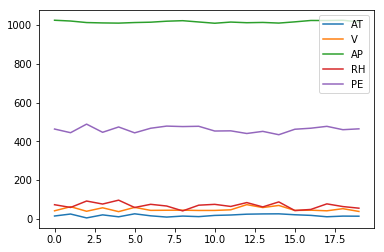

In [25]:
df[:20].plot()

### convert sequence set
- predict energy output from last 24 hours data
- 24시간의 센서 데이터를 통해 전기 에너지 생산량을 예측합니다
- 전기 에너지 생산량은 입력데이터에서 제외하겠습니다. 오직 센서데이터만을 사용해서 에너지 생산량을 예측하는 것으로 하겠습니다

In [26]:
x_arr = np.array(df.drop(columns=TARGET_COLUMN))
y_arr = np.array(df[TARGET_COLUMN])
x_arr.shape, y_arr.shape

((1000, 4), (1000,))

In [36]:
x_list = []
y_list = []
for i in range(len(x_arr) - sequence_train):
    train_sample = x_arr[i:i+sequence_train]
    test_sample = y_arr[i+sequence_train] 
    x_list.append(train_sample)
    y_list.append(test_sample)    

x_3d = np.stack(x_list,0)
y_1d = np.stack(y_list,0)
y_2d = np.expand_dims(y_1d, -1)
x_3d.shape, y_2d.shape


((976, 24, 4), (976, 1))

### [0,1] 의 값으로 정규화합니다

In [37]:
from sklearn.preprocessing import MinMaxScaler

In [38]:
x_3d_shape = x_3d.shape
x_2d_back = np.reshape(x_3d, [-1, x_3d.shape[-1]])
scaler_x = MinMaxScaler().fit(x_2d_back)
x_2d_normal = scaler_x.transform(x_2d_back)
x_3d_normal = np.reshape(x_2d_normal, x_3d_shape)

In [39]:
scaler_y = MinMaxScaler().fit(y_2d)
y_2d_normal = scaler_y.transform(y_2d)

### train/ test 셋을 분리합니다. 절반씩 나누었습니다 

In [40]:
x_train = x_3d_normal[::2]
y_train = y_2d_normal[::2]
x_test  = x_3d_normal[1::2]
y_test  = y_2d_normal[1::2]
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((488, 24, 4), (488, 24, 4), (488, 1), (488, 1))

###  tensorflow RNN modeling
- 모델 구현 방법은 다양합니다만 뉴럴넷에서 가장 많이 사용하는 conv, rnn, fc 만으로 단순하게 구성해보겠습니다
- convolution을 사용해 2시간 간격으로  5시간 동안의 데이터를 인코딩해줍니다. 시퀀스 길이가 절반으로 줄어들것입니다
- GRU 를 이용해 시퀀스 축에 따라서 인코딩합니다
- fc 가 GRU의 마지막 output 32개 채널을 받아서 에너지 생산량을 예측합니다

In [41]:
import tensorflow as tf
import tensorflow.contrib.slim as slim

In [42]:
tf.reset_default_graph()
def predict(net):
    print('net',net)
    net = slim.conv1d(net, 32, kernel_size=5, stride=2)
    
    print('net',net)
    cell = tf.keras.layers.GRUCell(32)
    outputs, state = tf.nn.dynamic_rnn(cell, net, dtype=tf.float32)
   
    net = slim.fully_connected(net[:,-1], 1)
        
    return net

In [52]:
PX = tf.placeholder(tf.float32, [None, x_train.shape[1], x_train.shape[2]])
PY = tf.placeholder(tf.float32, [None, y_train.shape[1]])
h = predict(PX)
cost = tf.reduce_mean(tf.square(PY - h))
r2 = 1-tf.reduce_sum(tf.square(PY - h)/ tf.reduce_sum(tf.square(PY - tf.reduce_mean(PY))))
opt = tf.train.GradientDescentOptimizer(0.1)
train_op = opt.minimize(cost)
sess = tf.Session()
sess.run(tf.global_variables_initializer())

net Tensor("Placeholder_2:0", shape=(?, 24, 4), dtype=float32)
net Tensor("Conv_1/Relu:0", shape=(?, 12, 32), dtype=float32)


In [54]:
EPOCH = 5000
DISPLAY_k = 10
for iter in range(EPOCH):
    _, _cost, _r2 = sess.run([train_op, cost, r2], {PX:x_train, PY:y_train})
    if iter % (EPOCH//DISPLAY_k) == 0:
        print('%d cost:%.5f r2:%.2f' %(iter, _cost, _r2))

0 cost:0.04792 r2:0.16
500 cost:0.04840 r2:0.16
1000 cost:0.04749 r2:0.17
1500 cost:0.04717 r2:0.18
2000 cost:0.04710 r2:0.18
2500 cost:0.04667 r2:0.19
3000 cost:0.04509 r2:0.21
3500 cost:0.04407 r2:0.23
4000 cost:0.04430 r2:0.23
4500 cost:0.04464 r2:0.22


### visualize 

In [55]:
predict_train = sess.run(h, feed_dict={PX:x_train})
predict_test = sess.run(h, feed_dict={PX:x_test})
y_train.shape, predict_train.shape

((488, 1), (488, 1))

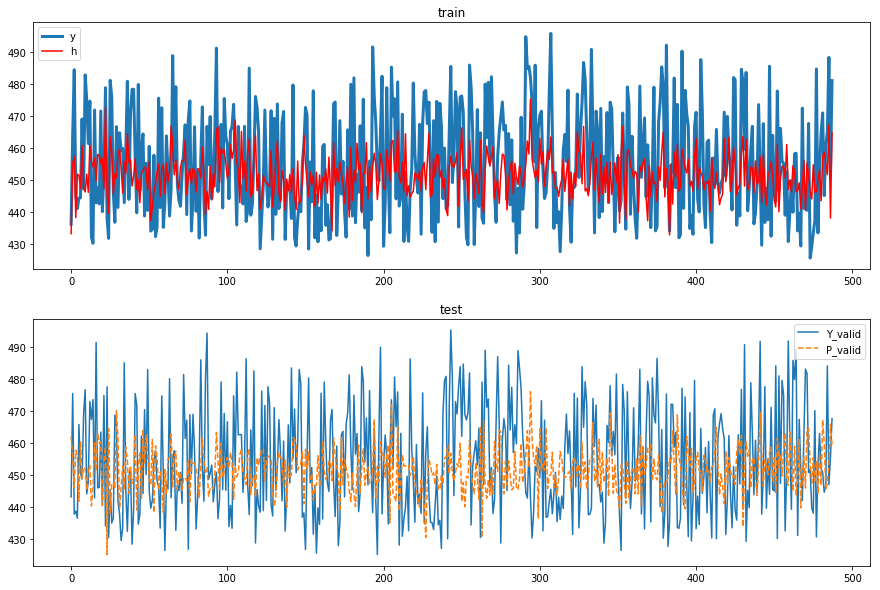

In [56]:
fig, axes = plt.subplots(2,1,figsize=(15,10))
axes[0].plot(scaler_y.inverse_transform(y_train),linewidth=3)
axes[0].plot(scaler_y.inverse_transform(predict_train),c='r',linestyle='-')
axes[0].set_title('train')
axes[0].legend(['y','h'])

axes[1].plot(scaler_y.inverse_transform(y_test))
axes[1].plot(scaler_y.inverse_transform(predict_test),linestyle='--')
axes[1].set_title('test')
axes[1].legend(['Y_valid','P_valid'])